In [1]:
# P.S currently tested on 3.10.7 python version, but these are standard packages and should work in other versions as well.
import numpy as np
#import matplotlib.pyplot as plt  # if you need to plot 
#from numba import njit, jit, guvectorize # NUMBA speed up quite a lot, see the functions that have the decorator just above ====> not used in this code
from scipy.optimize import brentq  # root-finding routine
from scipy.stats import norm


In [2]:

def tauchen(N, rho, sigma, mu=0.0, m=3.0):
    s1 = mu/(1 - rho) - m * np.sqrt(sigma**2 / (1 - rho**2))
    sN = mu/(1 - rho) + m * np.sqrt(sigma**2 / (1 - rho**2))
    s = np.linspace(s1, sN, N) # grid values
    step = (s[N-1] - s[0]) / (N - 1)  # evenly spaced grid
    P = np.zeros((N, N))

    for i in range(np.ceil(N/2).astype(int)):
        P[i, 0] = norm.cdf((s[0] - mu - rho*s[i] + step/2) / sigma)
        P[i, N-1] = 1 - norm.cdf((s[N-1] - mu - rho*s[i] - step/2) / sigma)
        for j in range(1, N-1):
            P[i, j] = norm.cdf((s[j] - mu - rho*s[i] + step/2) / sigma) - \
                      norm.cdf((s[j] - mu - rho*s[i] - step/2) / sigma)
    P[np.floor((N-1)/2+1).astype(int):, :] = P[0:np.ceil((N-1)/2).astype(int), :][::-1, ::-1]

    ps = np.sum(P, axis=1)
    P = P / ps[:, np.newaxis] # transition matrix

    # compute invariant distribution of labor process (by iteration)
    inv = np.ones(N) / N # initial guess
    tol=1E-11; maxit=100^4
    for it in range(maxit):
        inv_new = inv @ P
        if np.max(np.abs(inv_new - inv)) < tol: break  
        inv = inv_new # invariant distribution

    return s, P, inv

In [3]:
def setPar(
    beta = 0.95,
    rho = 0.9,
    sigma = 0.2,
    phi_mean = 1.0,
    alpha = 2/3,
    c_e = 40.0,
    c_f = 20.0,
    D_bar = 100.0,
    mu_g  = 0.0,
    sigma_g = 0.2,  
    nPhi = 101,
    w = 1.0 , 
    wedge = 0,
    wedgeprob = 0.05
):

	# === SHOCK DISCRETIZATION
    phi_mean = phi_mean*(1-rho)
    gPhi, F_trans, invPhi = tauchen(nPhi, rho, sigma, mu = phi_mean, m = 4.0)	
    gPhi = np.exp(gPhi)
    gPhi_wedge= np.vstack((gPhi, gPhi))  
        
	# === ENTRANTS DISTRIBUTION: Assume they draw from the invariant distribution.
    G_prob = invPhi
    G_prob_wedge= np.vstack((invPhi * (1-wedgeprob), invPhi* wedgeprob)).T
    # G_prob_wedge[0, :] *= (1-wedgeprob)
    #G_prob_wedge[1, :] *= wedgeprob
    
	# === WEDGE GRID and DISTRIBUTION: Assume 10% of firms with possitive wedge
    gwedge = np.linspace(1-wedge, 1+wedge, 2)
    
	# create dictionary with parameters
    param = {}
    param['alpha'] = alpha; param['beta'] = beta; param['F_trans'] = F_trans; param['gPhi'] = gPhi; param['nPhi'] = nPhi
    param['c_e'] = c_e; param['c_f'] = c_f; param['D_bar'] = D_bar; param['G_prob'] = G_prob; param['w'] = w
    param['wedge'] = wedge; param['gwedge'] = gwedge; param['wedgeprob'] = wedgeprob; param['G_prob_wedge']=G_prob_wedge
    param['gPhi_wedge']=gPhi_wedge
    return param

param = setPar()
#print(param)
#print(gwedge)

In [4]:
def solve_bellman(p_guess, param):
    # unpacking parameters
    gPhi = param['gPhi']; F_trans = param['F_trans']; alpha = param['alpha']; nPhi = param['nPhi']
    c_f = param['c_f']; beta = param['beta']; w = param['w']
    wedge = param['wedge']; gwedge = param['gwedge']; wedgeprob = param['wedgeprob']
    
    # static decision:
    gN = (p_guess * alpha * gPhi.reshape(-1, 1) / w)**(1 / (1.0 - alpha)) * gwedge.reshape(-1, 1).T
    gPi = p_guess * gPhi.reshape(-1, 1) * gwedge.reshape(-1, 1).T * gN**alpha  - w * gN - c_f * w

    # solve bellman
    tol = 1e-9
    max_iter = 500
    iter_count = 10
    print_it = False  # set true to print iterations
    V = gPi.copy()  # initial guess
    v_guess = np.zeros((nPhi, 2))

    for iter in range(0, max_iter):
        v_guess[:] = V  
        V[:,0] = gPi[:,0] + beta * np.maximum(0, F_trans.dot(v_guess[:,0])) 
        V[:,1] = gPi[:,1] + beta * np.maximum(0, F_trans.dot(v_guess[:,1])) 
        sup = np.max(np.abs(V - v_guess))  # check tolerance
        if sup < tol * np.max(np.abs(V)):
            if print_it: print(f"Iter: {iter}. Tol. achieved: {sup:.2E}")
            break
        if iter == max_iter and print_it: print(f"Max iterations achieved. VF did not converge: {sup:.2E}")
        if iter % iter_count == 0 and print_it: print(f"Iter: {iter}. Tol: {sup:.2E}")  
        
    chi = np.zeros((nPhi, 2))
    chi[F_trans.dot(V) < 0] = 1.0  # recover exit policy function 

    return V, chi, gN, gPi


V, chi, gN, gPi = solve_bellman(2, param) # test
#print( gN )
#print(gPi)

print(chi.shape)

(101, 2)


In [5]:
def solve_price(param):
    def entry(p_guess): # 
        c_e = param['c_e']; beta = param['beta']; G_prob = param['G_prob']; w = param['w']
        wedge = param['wedge']; gwedge = param['gwedge']; wedgeprob = param['wedgeprob'] ; G_prob_wedge=param['G_prob_wedge']
        V, chi, gN, gPi = solve_bellman(p_guess, param)
        excess_entry = beta * np.sum(V * G_prob_wedge) - c_e * w
        return excess_entry
    
    p0 = 0.05; p1 = 10.0 # guess: lower and upper bound. Might have to change for diff. parameters
    p = brentq(entry, 0.05, 10.0)

    V, chi, gN, gPi = solve_bellman(p, param)

    return p, V, chi, gN, gPi

sol =solve_price(param)
print(sol[0]) # price



1.252270632467577


In [6]:
def solve_m(param, solution):
    # unpacking parameters
    gPhi = param['gPhi']; F_trans = param['F_trans']; alpha = param['alpha']; nPhi = param['nPhi']
    G_prob = param['G_prob']; D_bar = param['D_bar']
    wedge = param['wedge']; gwedge = param['gwedge']; wedgeprob = param['wedgeprob'] 
    G_prob_wedge = param['G_prob_wedge']; gPhi_wedge = param['gPhi_wedge']
    
    p = solution[0]; chi = solution[2]; gN = solution[3];
    
    # construct transition probability:
    Phat_0= ((1 - chi[:,0]) * F_trans.T)  # note the transpose here, only firms with z>z* keep operating
    Phat_1 = ((1 - chi[:,1]) * F_trans.T)  # note the transpose here, only firms with z>z* keep operating
   
    # invariant distribution is just a homogeneous function of M
    def inv_dist(M):
        a0=M*G_prob @ np.linalg.inv(np.eye(nPhi) - Phat_0).T
        a1=M*G_prob @ np.linalg.inv(np.eye(nPhi) - Phat_1).T
        A=np.vstack((a0, a1)).T
        return A

    # supply: integrate the total production
    y = gPhi_wedge.T * gN**alpha
    supply = np.sum(inv_dist(1) * y) # just use the function with an arbitrary M
    
    #Measure of corruption:
    wedgecost = - gPhi_wedge.T * p * gPhi.reshape(-1, 1) * (gwedge.T-1) * gN**alpha  
    wedges = np.sum(inv_dist(1) * wedgecost) 
    # demand
    demand = (D_bar+wedges) / p
    
    # find mass of entrants (exploit linearity of the invariant distribution)
    M = demand / supply
    mu = inv_dist(M)
    
    return M, mu


M, mu = solve_m(param, sol)
print(M)
#print(mu)
np.sum(mu)


0.08477278909632234


1.0029987162620984

In [7]:
def ModelStats(param, sol_price, M, mu, Printa = True):
    # unpacking parameters
    gPhi = param['gPhi']; F_trans = param['F_trans']; alpha = param['alpha']; nPhi = param['nPhi']
    G_prob = param['G_prob']; D_bar = param['D_bar']
    wedge = param['wedge'] ; gwedge = param['gwedge'] ; wedgeprob =  param['wedgeprob']
    G_prob_wedge = param['G_prob_wedge']; gPhi_wedge = param['gPhi_wedge']
    p = sol_price[0]; chi = sol_price[2]; gN = sol_price[3]; gPi = sol_price[4]

    #Proba of corrupted firms
    corr_dist=np.array([[1 - wedgeprob], [wedgeprob]])
    # productivity distribution
    pdf_dist = mu.copy()
    pdf_dist[:,0] = mu[:,0] / np.sum(mu[:,0])
    pdf_dist[:,1] = mu[:,1] / np.sum(mu[:,1])
    
    cdf_dist = mu.copy()
    cdf_dist[:,0] = np.cumsum(pdf_dist[:,0])
    cdf_dist[:,1] = np.cumsum(pdf_dist[:,1])

    # employment distribution
    emp_dist = mu * gN 
    pdf_emp = emp_dist / np.sum(emp_dist)
    cdf_emp = np.cumsum(pdf_emp)
    
    # exit productivity
    cut_index_nc = np.flatnonzero(chi[:,0] == 0)[0]
    cut_index_c = np.flatnonzero(chi[:,1] == 0)[0]
    phicut_nc = gPhi[cut_index_nc]
    phicut_c = gPhi[cut_index_c]


    # stats
    avg_firm_size = np.sum(emp_dist) / np.sum(mu) 
    exit_rate = M / np.sum(mu* corr_dist.T) 
    Y = np.sum((gPhi_wedge.T * gN**alpha) * mu) # agg production
    emp_prod = np.sum(emp_dist )  # employment used in production
    Pi_c = np.sum(gPi[:,1] * mu[:,1] ) / np.sum(mu[:,1])   # average profits
    Pi_nc = np.sum(gPi[:,0] * mu[:,0] )/ np.sum(mu[:,0])  # average profits
    Pi = np.sum(gPi * mu )  # aggregate profits

    if Printa==True:
        print("Model Stats")
        print("Price: ", p)
        print("Avg. Firm Size: ", avg_firm_size)
        print("Exit/entry Rate: ", exit_rate)
        print("Productivity Cutoff for corrupt: ", phicut_c)
        print("Productivity Cutoff for non-corrupt: ", phicut_nc)
        print("Aggregate Output: ", Y)
        print("Profits for non-corrupt: ", Pi_nc)
        print("Profits for corrupt: ", Pi_c)
        print("Aggregate Profits: ", Pi_c+Pi_nc)

    
    return (pdf_dist, cdf_dist, pdf_emp, cdf_emp, avg_firm_size, exit_rate, Y, emp_prod, phicut_nc, phicut_c, Pi, gN)

Stats = ModelStats(param, sol, M, mu)

Model Stats
Price:  1.252270632467577
Avg. Firm Size:  66.46734994349254
Exit/entry Rate:  0.16903867915653437
Productivity Cutoff for corrupt:  2.819914364863605
Productivity Cutoff for non-corrupt:  2.819914364863605
Aggregate Output:  79.85494301894774
Profits for non-corrupt:  13.233674971746284
Profits for corrupt:  13.233674971746284
Aggregate Profits:  26.467349943492568


In [8]:
### PS. The function is not considering the corner solution where there is no entry. Change the function later.

def SolveModel(param):
    # Solve For Prices
	sol_price =solve_price(param)  
	M, mu = solve_m(param, sol_price)

	if M<=0: print("Warning: No entry, eq. not found.")
	stats = ModelStats(param, sol_price, M, mu)
	return (sol_price, M, mu, stats)

results = SolveModel(param)

Model Stats
Price:  1.252270632467577
Avg. Firm Size:  66.46734994349254
Exit/entry Rate:  0.16903867915653437
Productivity Cutoff for corrupt:  2.819914364863605
Productivity Cutoff for non-corrupt:  2.819914364863605
Aggregate Output:  79.85494301894774
Profits for non-corrupt:  13.233674971746284
Profits for corrupt:  13.233674971746284
Aggregate Profits:  26.467349943492568


In [9]:
# increase entry cost: 
results2 = SolveModel(setPar(wedge = 0.025))


Model Stats
Price:  1.2810576918203722
Avg. Firm Size:  69.64599843988216
Exit/entry Rate:  0.18567302604571584
Productivity Cutoff for corrupt:  2.620312230399254
Productivity Cutoff for non-corrupt:  2.92534679145905
Aggregate Output:  56.5197952411471
Profits for non-corrupt:  14.01204677038464
Profits for corrupt:  15.823588228656604
Aggregate Profits:  29.835634999041243


In [10]:
# increase entry cost: 
results3 = SolveModel(setPar(wedge = 0.025, wedgeprob=0.25))


Model Stats
Price:  1.2668320959379182
Avg. Firm Size:  67.35150075924005
Exit/entry Rate:  0.17177280259044164
Productivity Cutoff for corrupt:  2.620312230399254
Productivity Cutoff for non-corrupt:  2.92534679145905
Aggregate Output:  57.87210168423426
Profits for non-corrupt:  12.891514878004596
Profits for corrupt:  14.643374836010898
Aggregate Profits:  27.534889714015492


(101, 2)


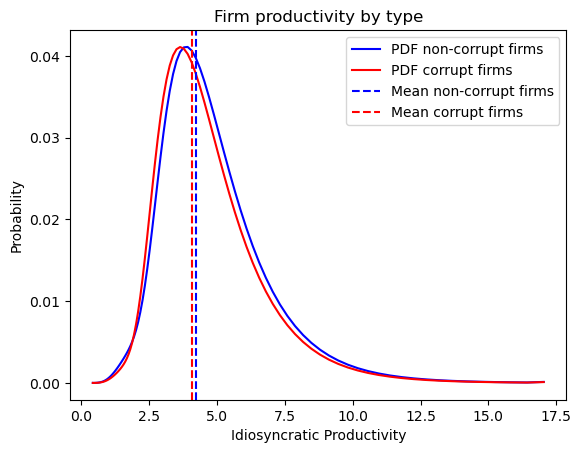

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'results2' is a tuple and the 4th element contains the desired values
# Unpack relevant values from results2
pdf_dist, cdf_dist, pdf_emp, cdf_emp, avg_firm_size, exit_rate, Y, emp_prod, phicut_nc, phicut_c, Pi, gN = results2[3]

print(pdf_dist.shape)

# Calculate the means of each PDF
mean_non_corrupt = np.sum(param['gPhi'] * pdf_dist[:, 0] )
mean_corrupt = np.sum(param['gPhi'] * pdf_dist[:, 1])

# Plotting pdf_dist
fig, ax = plt.subplots()
# Plot first column of pdf_dist in blue
ax.plot(param['gPhi'], pdf_dist[:, 0], color='blue', label='PDF non-corrupt firms')
# Plot second column of pdf_dist in red
ax.plot(param['gPhi'], pdf_dist[:, 1], color='red', label='PDF corrupt firms')

# Add vertical lines for the means
ax.axvline(x=mean_non_corrupt, color='blue', linestyle='--', label='Mean non-corrupt firms')
ax.axvline(x=mean_corrupt, color='red', linestyle='--', label='Mean corrupt firms')

ax.set_xlabel('Idiosyncratic Productivity')
ax.set_ylabel('Probability')
ax.set_title('Firm productivity by type')
ax.legend()

plt.show()
